In [852]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [853]:
cm = 3
mN = 1

# V2 = 1e-4
V2 = 1

modes_dt = {0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.81e4}, 
            1: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.86e2*V2},
            2: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.26e6*V2}
           }

In [854]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [855]:
tr_te_size = 0.5 
df_train, df_test = load_train_test(modes_dt, tr_te_size)

train size: 6303 (50.01%); test size: 6301 (49.99%)
data points per mode:  [540, 6099, 5965]


In [856]:
def relabel(x):
    if x == 0 :    # bkg
        return 0
    elif x == 1:     # s-channel signal
        return 1
    if x == 2 :    # t-channel signal
        return 1

In [857]:
features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton 4 momentum info
            'DeltaPhijjl', 'DeltaRjjl',          # Delta R between jj(from W boson) and lepton
            'ptJJ', 'etaJJ', 'mJJ',     # jj(from W boson) 4 momentum info
            'mN', 'ptN', 'pzN'           # reconstructed N 4 momentum info
           ]

# features = ['ptLep', 'ELep', 'mJJ', 
#             'mN']


In [858]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [859]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_train.target)

In [860]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.weight.values);
# xgbc1.fit(X_train, y_train);

In [861]:
# transform the BDT output to score
def soft(prob, target):
    return np.exp(prob[:, target])/(np.exp(prob).sum(axis=1)) 

# scores for training
df_bdt_train_s = df_train[['target', 'weight']]
df_bdt_train_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_train), 1)

# score for testing 
df_bdt_test_s = df_test[['target', 'weight']]
df_bdt_test_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_test), 1)

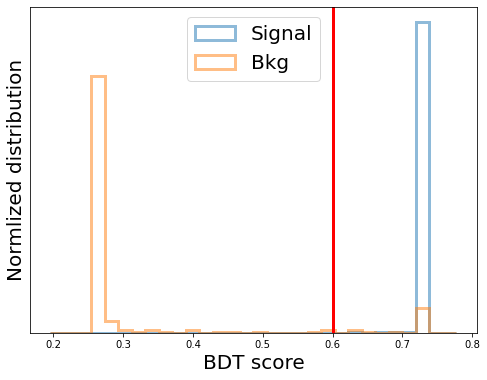

In [862]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==1)]['pred1'].max() 
pred0_min = df_plot[(df_plot.target==1)]['pred1'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]


ax1.hist(df_plot[(df_plot.target==1)]['pred1'], weights=df_plot[df_plot.target==1]['weight'], bins=30, range=range_, density=True, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==0)]['pred1'], weights=df_plot[df_plot.target==0]['weight'], bins=30, range=range_, density=True, histtype='step', lw=3, label=r'Bkg', alpha=0.5);

# ax1.set_yscale('log')

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)


threshold = 0.6
ax1.axvline(threshold, color='red', lw=3)



In [863]:
len(df_bdt_test_s[(df_bdt_test_s['pred1'] >= threshold) & (df_bdt_test_s['target'] == 1)]),\
len(df_bdt_test_s[(df_bdt_test_s['pred1'] >= threshold) & (df_bdt_test_s['target'] == 0)])

(5998, 25)

In [864]:

V2_after = 1

b, s = \
df_bdt_test_s[(df_bdt_test_s['pred1'] >= threshold) & (df_bdt_test_s['target'] == 0)]['weight'].sum() / tr_te_size, \
df_bdt_test_s[(df_bdt_test_s['pred1'] >= threshold) & (df_bdt_test_s['target'] == 1)]['weight'].sum() / tr_te_size * V2_after

b, s

(1675.9259259259259, 1255748.6907072698)

In [865]:
s / (s + b)**0.5

1119.8549006437984

In [866]:
N = 1.96
# N = 1.645

M = N**2

upper, lower = ((M+(M**2 + 4*M*b)**0.5)/2)/(s/V2), ((M-(M**2 + 4*M*b)**0.5)/2)/(s/V2)
print("upper limit:", upper)
print("lower limit:",lower)

upper limit: 6.544495211133464e-05
lower limit: -6.238574127685127e-05


In [867]:
scores = xgbc1.get_booster().get_score()
dict(sorted(scores.items(), key=lambda item: item[1]*-1))

{'mN': 320.0,
 'ELep': 162.0,
 'etaLep': 159.0,
 'pzN': 154.0,
 'mJJ': 135.0,
 'ptJJ': 123.0,
 'ptN': 122.0,
 'ptLep': 103.0,
 'etaJJ': 90.0,
 'DeltaPhijjl': 89.0,
 'DeltaRjjl': 72.0,
 'chargeLep': 15.0}